# Preamble
This jupyter notebook is used to analyze and visualize all synthetic tRNA data we are considering for an upcoming manuscript.

The below cell blocks import all the necessary modules and define functions used for loading and normalizing the data

## Imports

In [1]:
from typing import Iterable, Callable
from itertools import takewhile

import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ks_2samp
import pandas as pd
import seaborn as sns

from matplotlib.axes import Axes
import matplotlib.pyplot as plt

## Data Loading and Analysis

In [2]:
# functions
def smoothing(df: pd.DataFrame, key: str, kernel_width: float) -> np.ndarray:
    return gaussian_filter1d(df[key], sigma=kernel_width)


# FUNCTION NOT USED! KEPT HERE FOR REFERENCE IMPLEMENTATION
#
# def derivative(df: pd.DataFrame, key: str = "smoothed_fluorescence") -> np.ndarray:
#     # calculate timestep
#     time = df.time.map(lambda t: pd.to_datetime(t))
#     dt = int(np.diff(time).mean()) / 1e9  # in seconds
#
#     # calculate derivative
#     grad = np.gradient(df[key]) / dt
#     return grad


def rolling_average(arr: Iterable, width: int = 5) -> np.ndarray:
    window = np.ones(width) / width
    return np.convolve(arr, window, mode="same")


def load_namemap(platemap_filepath: str) -> dict:
    # load map of conditions to plate locations (.csv)
    platemap = (
        pd.read_csv(platemap_filepath)
        .dropna()
        .set_index("Rows/Cols")
        .T
        .unstack()
    )
    platemap = platemap[platemap != '-']

    # extract location names from platemap index
    locs = [
        "".join(loc_tup)
        for loc_tup in platemap.index
    ]
    # extract conditions from platemap values
    conditions = platemap.values

    # make dict mapping locations to conditions
    namemap = dict(zip(locs, conditions))

    return namemap


def load_experiment(
        data_filepath: str, namemap: dict, date: str,
        smoothing_parameter: float,
        rolling_average_window_length: int,
) -> pd.DataFrame:
    # load dataframe and massage
    df = (
        pd.read_csv(data_filepath)
        .drop(["Unnamed: 0", "Temperature(¡C)"], axis=1)
        .set_index("Time")
    )

    # generate dataframe for each replicate
    dict_of_dfs_raw = {
        loc: pd.DataFrame.from_dict(
            {
                "loc": loc,
                "time": df[loc].index,
                "fluorescence": df[loc].values,
                "condition": cond
            }
        )
        for loc, cond in namemap.items()
    }
    # calculate smoothed fluorescence trace for each replicate
    for _, df in dict_of_dfs_raw.items():
        df["smoothed_fluorescence"] = smoothing(df, key="fluorescence", kernel_width=smoothing_parameter)

    # calculate background fluorescence to subtract from traces
    negs = pd.concat([
        dict_of_dfs_raw[loc]
        for loc, cond in namemap.items()
        if cond == "(-)"
    ])
    background = negs.groupby("time")["smoothed_fluorescence"].mean()

    # iterate over unnormalized dict of dfs
    dict_of_dfs_processed = {}
    for loc, df in dict_of_dfs_raw.items():
        # background subtraction
        backgroud_corrected_fluorescence = df["fluorescence"] - background.values
        smoothed_fluorescence = df["smoothed_fluorescence"] - background.values

        # calculate timestep
        time = df.time.map(lambda t: pd.to_datetime(t))
        dt = int(np.diff(time).mean()) / 1e9  # in seconds

        # calculate derivative
        grad = np.gradient(smoothed_fluorescence) / dt

        # calculate rolling average of derivative
        rolling_average_derivative = rolling_average(grad, rolling_average_window_length)

        dict_of_dfs_processed[loc] = pd.DataFrame.from_dict(
            {
                "date": date,
                "loc": loc,
                "condition": df["condition"],
                "time": df["time"],
                "raw_fluorescence": df["fluorescence"],
                "bkgrd_sub_fluorescence": backgroud_corrected_fluorescence,
                "smoothed_not_bkgrd_sub": df["smoothed_fluorescence"],
                "smoothed_fluorescence": smoothed_fluorescence,
                "derivative": grad,
                "smoothed_derivative": gaussian_filter1d(grad, smoothing_parameter),
                "rolling_derivative": rolling_average_derivative,
            }
        )

    # turn dictionary of processed dataframes into one big dataframe
    df = pd.concat(dict_of_dfs_processed.values()).reset_index()

    return df


def load_data(
        # date -> (platemap_filepath, data_filepath)
        experiment_filepaths: dict[str, tuple[str, str]],
        smoothing_parameter: float = 0.5,
        rolling_average_window_length: int = 5,
) -> pd.DataFrame:
    # load dataframes for each day of experiments
    list_of_dfs = [
        load_experiment(
            data_filepath=data_filepath, namemap=load_namemap(platemap_filepath), date=date,
            smoothing_parameter=smoothing_parameter,
            rolling_average_window_length=rolling_average_window_length
        )
        for date, (platemap_filepath, data_filepath) in experiment_filepaths.items()
    ]
    # concatenate list of dataframes into one big dataframe and return
    data = pd.concat(list_of_dfs).reset_index(drop=True)
    return data


def remove_outliers_timeseries(df: pd.DataFrame) -> pd.DataFrame:
    # get dataframe with single row per experimental replicate
    vmax_df = df[df["index"] == 42]

    # MANUALLY IDENTIFIED OUTLIERS!
    outlier_ix = {
        # 220728
        42,  # GAfast
        235, 2937,  # GAslow
    }
    # get pd.Series for each row identified by outlier_ix
    outlier_series = [vmax_df.loc[ix] for ix in outlier_ix]

    # create list of dicts of comparables (key -> Any)
    # and each
    outlier_identifiers = [
        {key: series[key] for key in "date loc".split()}  # each item represents the val of the outlier
        for series in outlier_series  # each dict represents a single outlier
    ]

    # generate masks to identify outliers by comparing df to those key, value pairs
    each_outlier_mask = []
    for outlier_dict in outlier_identifiers:
        # generate mask to find indices that match each individual key val pair
        #   for a given outlier
        each_outlier_keyval_mask = [
            df[key] == val
            for key, val in outlier_dict.items()
        ]

        # generate mask for each outlier, which is where all keyval pair
        each_outlier_mask.append(np.logical_and.reduce(each_outlier_keyval_mask))

    # generate masks for all outliers, which is where any mask is TRUE
    combined_mask = np.logical_or.reduce(each_outlier_mask)

    # return NOT outliers
    return df[~combined_mask]



## Getter Functions

In [3]:
# GETTER FUNCTIONS
def make_getter_function(conditions: Iterable[str]) -> Callable[[pd.DataFrame], pd.DataFrame]:
    def get_conditions(df: pd.DataFrame) -> pd.DataFrame:
        filtered = df[df["condition"].map(lambda cond: cond in conditions)]
        return filtered
    return get_conditions


get_experimental_conditions = make_getter_function({"GAfast", "GAslow", "(-)", "uniform", "Uniform"})
get_traces_conditions = make_getter_function({"GAfast", "GAslow", "(-)", "uniform"})
get_barplot_conditions = make_getter_function({"GAfast", "GAslow", "uniform"})
get_designed_conditions = make_getter_function({"GAfast", "GAslow"})
get_syn_tRNAs = make_getter_function({"GAfast", "GAslow", "uniform"})
get_init_met_conditions = make_getter_function({'(-)', '0 uM', '1 uM','10 uM', '2 uM', '20 uM', '5 uM', '50 uM'})

## Plotting Functions

In [4]:
# PLOTTING PARAMETERS
hue_order = "uniform GAslow GAfast (-)".split()
cmap = dict(zip(hue_order, sns.color_palette()))
cmap["Uniform"] = cmap["uniform"]
cmap["(-)"] = (0, 0, 0)
cmap["(+)"] = (0, 0, 0)

init_conc_series = ['0 uM', '1 uM', '2 uM', '5 uM', '10 uM', '20 uM', '50 uM']
init_hue_order = ["(-)"] + init_conc_series
init_cmap = dict(zip(
    init_conc_series,
    sns.color_palette("viridis", len(init_conc_series))
))
init_cmap["(-)"] = (0, 0, 0)

def set_xaxis_time(ax, tight: bool = False, last_timepoint: str = "12hrs") -> Axes:
    tick_names = ["0hrs", "4hrs", "8hrs", "12hrs", "16hrs"]
    n = len(tick_names)
    tick_locs = [int(i / (n - 1) * len(ax.get_xticks())) for i in range(n)]
    tick_dict = dict(zip(tick_names, tick_locs))

    if last_timepoint is not None:
        # truncate plot
        ax.set_xlim(0, tick_dict[last_timepoint])
        # truncate tick_names and tick_locs
        tick_names, tick_locs = list(zip(*takewhile(lambda tup: tup[1] <= tick_dict[last_timepoint], tick_dict.items())))

    if tight:
        # only take first and last values of tick_names and tick_locs
        tick_names = [tick_names[0], tick_names[-1]]
        tick_locs = [tick_locs[0], tick_locs[-1]]

    ax.set_xticks(tick_locs, tick_names)

    return ax


def plot_line_seaborn(
        df: pd.DataFrame,
        xkey="time", ykey="bkgrd_sub_fluorescence",
        traces=False,
        ax=None,
        legend: bool = True,
        format_xaxis: bool = True, time_tight: bool = False,
        outpath: str = None,
) -> Axes:
    if ax is None:
        _, ax = plt.subplots()

    estimator = "mean" if traces is False else None
    sns.lineplot(
        data=df, x=xkey, y=ykey,
        hue="condition", alpha=0.5,
        palette=cmap, legend=legend,
        estimator=estimator,
        ax=ax
    )
    if ykey == "derivative":
        plt.legend(loc="lower right")

    if format_xaxis:
        ax = set_xaxis_time(ax, time_tight)

    if outpath is not None:
        plt.savefig(outpath)

    return ax


def plot_trace(
        # data analysis parameters
        plotted: pd.DataFrame,
        threshkey: str = None,
        left_threshold: float = None, right_threshold: float = None,
        # specify variables to plot
        xkey: str = "time",
        ykey: str = "bkgrd_sub_fluorescence", ystyle: str = "-",
        y2key: str = None, y2style: str = ":",
        # plotting parameters
        ax: Axes = None,
        format_xaxis: bool = True,
        plot_bounds: bool = True,                                   # plot integration bounds?
        ylim: tuple[float, float] = None,
        plot_title: str = None,
        linewidth: float = 1,
        outpath: str = None
):
    if ylim is None:
        vals = [
            val
            for key in (ykey, y2key) if key is not None
            for val in plotted[key]
        ]
        ylim = (min(vals), max(vals))

    if ax is None:
        _, ax = plt.subplots()

    cond = set(plotted["condition"]).pop()

    x = plotted[xkey]
    y1 = plotted[ykey]

    # plot data
    ax.plot(x, y1, ystyle, color=cmap[cond], linewidth=linewidth)

    if y2key is not None:
        y2 = plotted[y2key]
        ax.plot(x, y2, y2style, color=cmap[cond], linewidth=linewidth)


    if plot_bounds:
        # plot horizontal line across y=0
        ax.plot(np.zeros_like(y1), '--k', linewidth=linewidth)

        # get vertical lines for this trace
        vert = np.linspace(ylim[0], ylim[1], len(y1))

        # get xval arrays for vertical lines at integration bounds
        lowix, highix = get_integration_bounds(
            plotted, threshkey=threshkey,
            left_threshold=left_threshold, right_threshold=right_threshold
        )
        lowbound = np.ones_like(x) * lowix
        highbound = np.ones_like(x) * highix

        # plot integration bounds
        ax.plot(lowbound, vert, "--k", linewidth=linewidth)
        ax.plot(highbound, vert, "--k", linewidth=linewidth)

    if format_xaxis:
        ax = set_xaxis_time(ax)

    if plot_title is not None:
        ax.set_title(plot_title)

    if outpath is not None:
        plt.savefig(outpath)

    return ax


def plot_traces(
       # data analysis parameters
        plotted: pd.DataFrame,
        threshkey: str = None,
        left_threshold: float = None, right_threshold: float = None,
        # specify variables to plot
        huekey: str = "condition",
        xkey: str = "time",
        ykey: str = "bkgrd_sub_fluorescence", ystyle: str = "-",
        y2key: str = None, y2style: str = ":",
        # plotting parameters
        ax: Axes = None,
        format_xaxis: bool = True,
        plot_bounds: bool = True,                                   # plot integration bounds?
        ylim: tuple[float, float] = None,
        plot_title: str = None,
        linewidth: float = 1,
        outpath: str = None
):
    if ylim is None:
        vals = [
            val
            for key in (ykey, y2key) if key is not None
            for val in plotted[key]
        ]
        ylim = (min(vals), max(vals))

    if ax is None:
        _, ax = plt.subplots()

    for hueval, df in plotted.groupby(huekey):
        ax = plot_trace(
            plotted=df, threshkey=threshkey, left_threshold=left_threshold, right_threshold=right_threshold,
            xkey=xkey, ykey=ykey, ystyle=ystyle, y2key=y2key, y2style=y2style,
            ax=ax, format_xaxis=False, plot_bounds=plot_bounds, linewidth=linewidth, ylim=ylim
        )
    if plot_title is not None:
        ax.set_title(plot_title)

    if outpath is not None:
        plt.savefig(outpath)

    return ax


def plot_traces_grid(
        # data analysis parameters
        plotted: pd.DataFrame,
        threshkey: str = None, left_threshold: float = None, right_threshold: float = None,
        # specify plot layout
        rowkey: str = "condition", colkey: str = "loc",
        # specify variables to plot
        xkey: str = "time", ykey: str = "bkgrd_sub_fluorescence",
        y2key: str = None,
        # plotting parameters
        figsize: tuple[float, float] = (10, 5),
        plot_bounds: bool = True,                                   # plot integration bounds?
        plot_title: str = None,
        ylim: tuple[float, float] = None,
        tight_xaxis_labels: bool = True,
        outpath: str = None
):
    # flag if plot_bounds need to be calculated for each row
    calc_ylim = (ylim is None)

    # group data by rowkey
    list_df_by_rowkey = list(plotted.groupby(rowkey))

    # get number of valid columns per condition
    ncols_per_row = {
        row: len(set(df[colkey]))
        for row, df in list_df_by_rowkey
    }

    # get dimensions of subplots
    nrows = len(list_df_by_rowkey)
    ncols = max(ncols_per_row.values())

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(h_pad=2)

    # iterate through conditions and plot
    for (row, df_by_row), ax_rows in zip(list_df_by_rowkey, axes):

        # get plot bounds if not specified
        if calc_ylim:
            vals = [
                val
                for key in (ykey, y2key) if key is not None
                for val in df_by_row[key]
            ]
            ylim = (min(vals), max(vals))

        if ncols == 1:
            ax_rows = [ax_rows]  # ax rows should be a list, but rn is just an Axes object

        for (col, df), ax in zip(df_by_row.groupby(colkey), ax_rows):
            for (_, plotted) in df.groupby("loc"):
                ax = plot_trace(
                    plotted=plotted,
                    threshkey=threshkey, left_threshold=left_threshold, right_threshold=right_threshold,
                    xkey=xkey, ykey=ykey, y2key=y2key,
                    ax=ax, plot_bounds=plot_bounds, ylim=ylim,
                    format_xaxis=False
                )

                # format
                ax.set_title(f"{row} {col}")

                ax.set_ylim(ylim)

            set_xaxis_time(ax, tight=tight_xaxis_labels)

    if plot_title is not None:
        plt.suptitle(plot_title)
        plt.subplots_adjust(top=0.85)

    if outpath is not None:
        plt.savefig(outpath)

    return fig, axes


## Calculate Translation Rates

In [5]:
def get_integration_bounds(
        df: pd.DataFrame,
        threshkey: str,
        left_threshold: float, right_threshold: float,
) -> tuple[int, int]:
    """
    dataframe MAY be grouped by date and condition already
    (will work on single trace dataframes)
    """
    mean_trace = df.groupby("time")[threshkey].mean()[:12 * 12]

    lowix = int(np.argmax(mean_trace >= left_threshold * max(mean_trace)))

    reverse_indices = np.arange(len(mean_trace))[::-1]
    highix = int(reverse_indices[np.argmax(mean_trace[::-1] >= right_threshold * max(mean_trace))])

    return lowix, highix


def get_average_rate(
        df: pd.DataFrame,
        bound_ix: tuple[float, float],
        integratekey: str,
        vmax=False
) -> float:
    """
    12 ~ 1 hr
    36 ~ 3 hrs
    48 ~ 4 hrs
    """
    if vmax is True:
        return max(df[integratekey])
    else:
        ix0, ix1 = bound_ix
        time = df.time.map(lambda t: pd.to_datetime(t))
        dt = int(np.diff(time).mean()) / 1e9  # in seconds
        time_window = (ix1 - ix0 + 1) * dt
        integral = df.iloc[ix0:ix1 + 1][integratekey].sum()
        integral /= time_window
        return integral


def norm_by_GAfast(data: pd.DataFrame) -> pd.DataFrame:
    def normalize(df: pd.DataFrame):
        GA_fast_mean = df[df.condition == "GAfast"]["average_rate"].mean()
        df["normalized_rate"] = df["average_rate"] / GA_fast_mean

        return df

    data = data.groupby("date").apply(normalize)
    data["elong_norm"] = 1 / data["normalized_rate"]
    return data


def get_avg_rate_df(
        df: pd.DataFrame, leftthresh: float, rightthresh: float,
        threshkey: str = "derivative", integratekey: str = "derivative", vmax=False
) -> pd.DataFrame:
    avg_rate_dicts = [
        {
            "date": date,
            "loc": loc,
            "condition": cond,
            "average_rate": get_average_rate(
                df=df,
                bound_ix=get_integration_bounds(
                    df=df, threshkey=threshkey,
                    left_threshold=leftthresh, right_threshold=rightthresh
                ),
                integratekey=integratekey,
                vmax=vmax
            )
        }
        for (date, cond), df_by_cond in df.groupby(["date", "condition"])
        for loc, df in df_by_cond.groupby("loc")
    ]
    avg_rate_series = [
        pd.Series(data=d, index=d.keys())
        for d in avg_rate_dicts
    ]
    avg_rate_df = pd.concat(avg_rate_series, axis=1).T
    return avg_rate_df


# Main Figures

## Load Data

In [8]:
experiments = {
    # date -> (platemap_filepath, data_filepath)
    "220728": (
        "experimental_data/220728_platemap.csv", 
        "experimental_data/220728_fluorescence_data.csv"
    ),
    "220801": (
        "experimental_data/220801_platemap.csv", 
        "experimental_data/220801_fluorescence_data.csv"
    ),
    "221207": (
        "experimental_data/221207_platemap.csv", 
        "experimental_data/221207_fluorescence_data.csv"
    )
}

sigma=10
left_thresh = 0.50
right_thresh = 0.50
thresh_key = "smoothed_derivative"
integrate_key = "smoothed_derivative"
barplotval = "normalized_rate"
vmax_flag = False


data_df = load_data(experiment_filepaths=experiments, smoothing_parameter=sigma)
no_outliers = remove_outliers_timeseries(data_df)
rate_df = norm_by_GAfast(
    get_avg_rate_df(
        get_barplot_conditions(no_outliers),
        threshkey=thresh_key, integratekey=integrate_key,
        leftthresh=left_thresh, rightthresh=right_thresh,
        vmax=vmax_flag
    )
)
rate_w_outliers = norm_by_GAfast(
    get_avg_rate_df(
        get_barplot_conditions(data_df),
        threshkey=thresh_key, integratekey=integrate_key,
        leftthresh=left_thresh, rightthresh=right_thresh,
        vmax=vmax_flag
    )
)

/var/folders/yv/d5jpg6nn2y3bz11ly66149y00000gn/T/ipykernel_6058/494440794.py:50: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby("date").apply(normalize)
/var/folders/yv/d5jpg6nn2y3bz11ly66149y00000gn/T/ipykernel_6058/494440794.py:50: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

## Translation rate bar graph

In [9]:
means = {
    "uniform": 177.331,
    "GAfast": 160.291,
    "GAslow": 220.749
}
norm_rates = {
    cond: means["GAfast"] / mean
    for cond, mean in means.items()
}
len_arr = 100
vert = np.linspace(0,1, len_arr)
vertical_lines = {
    # cond: (xarr, yarr)
    cond: (np.ones(len_arr)*rate, vert)
    for cond, rate in norm_rates.items()
}

/var/folders/yv/d5jpg6nn2y3bz11ly66149y00000gn/T/ipykernel_6058/3930193329.py:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(


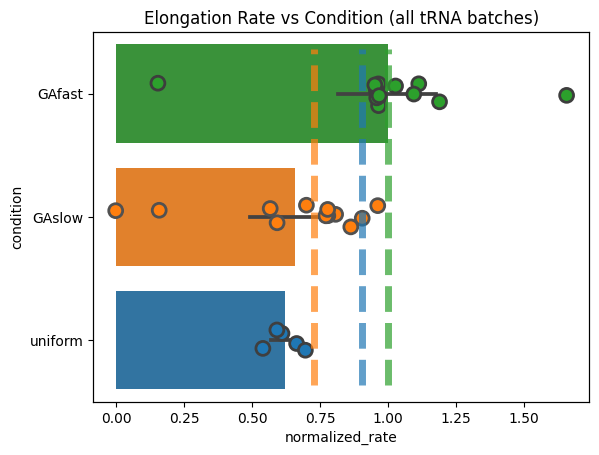

In [10]:
plotted = get_barplot_conditions(rate_w_outliers)

ax = sns.stripplot(
    data=plotted, x=barplotval, y="condition",
    palette=cmap, size=10, linewidth=2
)
ax = sns.barplot(
    data=plotted, x=barplotval, y="condition",
    hue_order=hue_order, palette=cmap, orient="h",
    ax=ax
)
ax.set_title(f"Elongation Rate vs Condition (all tRNA batches)")

ax2 = ax.twinx()

for cond, (xarr, yarr) in vertical_lines.items():
    ax2.plot(xarr, yarr, "--", color=cmap[cond], linewidth=5, alpha=0.7)
ax2.get_yaxis().set_visible(False)

# plt.savefig(f"figures/all_rates_bar_plot.svg")

## 220801 representative traces

### raw traces

(-5000.0, 30000.0)

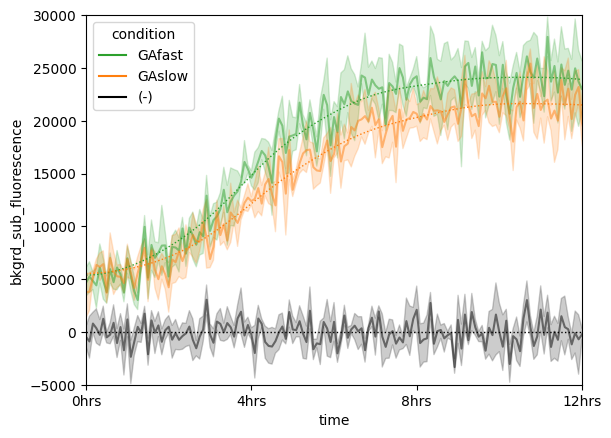

In [11]:
df = get_traces_conditions(data_df)
plotted = df[df["date"] == "220801"]
means = plotted.groupby(["condition", "time"])["smoothed_fluorescence"].mean().reset_index()
ax = plot_line_seaborn(plotted, ykey="bkgrd_sub_fluorescence", format_xaxis=False, legend=True)
ax = plot_traces(
    plotted=means,
    ykey="smoothed_fluorescence", ystyle=":",
    ax=ax, format_xaxis=False,
    plot_bounds=False
)
set_xaxis_time(ax, last_timepoint="12hrs")
ax.set_ylim([-5000, 30000])
# plt.savefig("figures/220801_raw_traces.svg")

### mean derivative

<Axes: xlabel='time', ylabel='smoothed_derivative'>

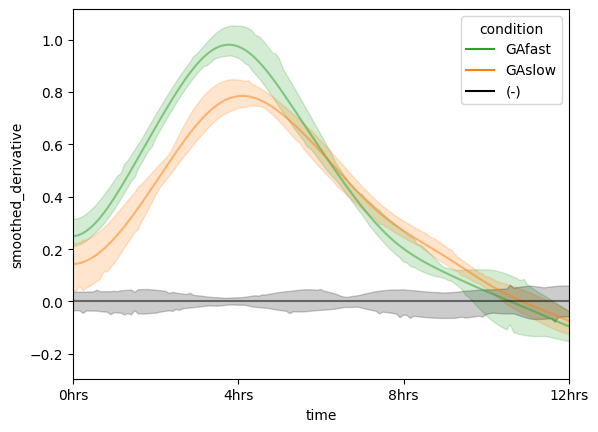

In [13]:
df = get_traces_conditions(data_df)
plotted = df[df["date"]=="220801"]
plot_line_seaborn(
    df=plotted, ykey="smoothed_derivative", 
    # outpath="figures/220801_mean_derivative_vs_condition.svg",
)

## all traces vs day

### raw traces

(<Figure size 1000x800 with 9 Axes>,
 array([[<Axes: title={'center': '220728 GAfast'}>,
         <Axes: title={'center': '220728 GAslow'}>, <Axes: >],
        [<Axes: title={'center': '220801 GAfast'}>,
         <Axes: title={'center': '220801 GAslow'}>, <Axes: >],
        [<Axes: title={'center': '221207 GAfast'}>,
         <Axes: title={'center': '221207 GAslow'}>,
         <Axes: title={'center': '221207 uniform'}>]], dtype=object))

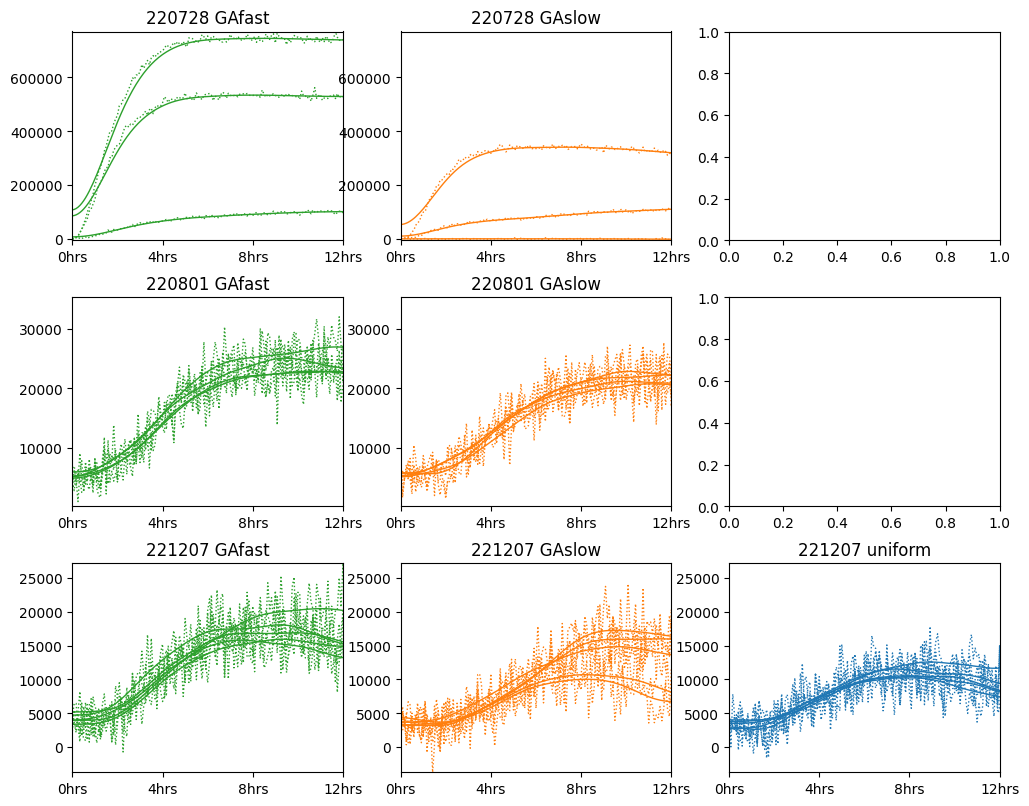

In [14]:
plotted = get_barplot_conditions(data_df)
plot_traces_grid(
    plotted=plotted, 
    threshkey=thresh_key, left_threshold=left_thresh, right_threshold=right_thresh,
    rowkey="date", colkey="condition",
    ykey="smoothed_fluorescence", 
    y2key="bkgrd_sub_fluorescence",
    plot_bounds=False,
    tight_xaxis_labels=False,
    figsize=(10,8), 
    # outpath="figures/fluorescence_vs_replicate.svg"
)

### derivatives 

(<Figure size 1000x800 with 9 Axes>,
 array([[<Axes: title={'center': '220728 GAfast'}>,
         <Axes: title={'center': '220728 GAslow'}>, <Axes: >],
        [<Axes: title={'center': '220801 GAfast'}>,
         <Axes: title={'center': '220801 GAslow'}>, <Axes: >],
        [<Axes: title={'center': '221207 GAfast'}>,
         <Axes: title={'center': '221207 GAslow'}>,
         <Axes: title={'center': '221207 uniform'}>]], dtype=object))

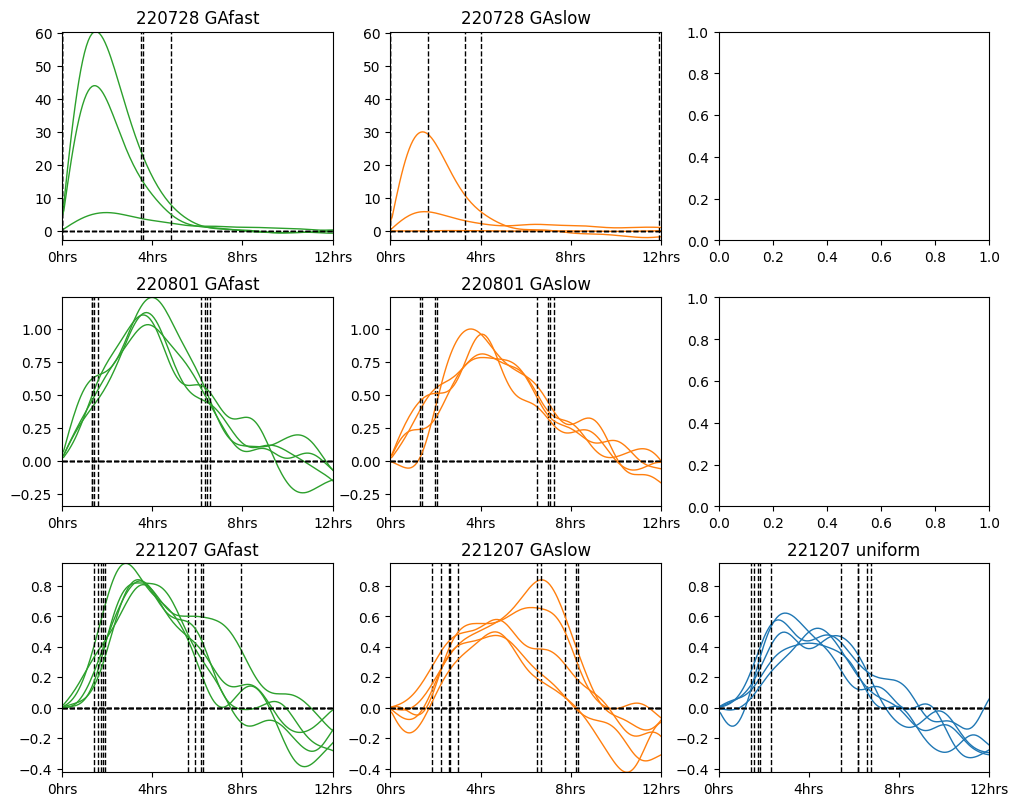

In [15]:
plotted = get_barplot_conditions(data_df)
plot_traces_grid(
    plotted=plotted, 
    threshkey=thresh_key, left_threshold=left_thresh, right_threshold=right_thresh,
    rowkey="date", colkey="condition",
    ykey="derivative", 
    # y2key="bkgrd_sub_fluorescence",
    plot_bounds=True,
    tight_xaxis_labels=False,
    figsize=(10,8), 
    # outpath="figures/derivatives_vs_loc.svg"
)

## Integration Parameter Sweep

In [18]:
def correlate_bounds(thresh: str):
    bounds_set = {
        "(10%, 10%)": (0.1, 0.1),
        "(25%, 25%)": (0.25, 0.25),
        "(50%, 50%)": (0.5, 0.5),
        "(75%, 75%)": (0.75, 0.75),
        "(90%, 90%)": (0.9, 0.9),
        "(10%, 90%)": (0.1, 0.9),
    }
    rate_dfs = {
        bound_name: get_barplot_conditions(norm_by_GAfast(
            get_avg_rate_df(
                get_barplot_conditions(no_outliers),
                threshkey=threshkey,
                leftthresh=left, rightthresh=right
            )
        ))["average_rate"]
        for bound_name, (left, right) in bounds_set.items()
    }
    rate_vs_bounds_df = pd.DataFrame.from_dict(rate_dfs)
    corr = rate_vs_bounds_df.astype("float").corr(method="spearman")
    sns.heatmap(data=corr, cbar="viridis", vmin=0.8)
    outpath = f"figures/{threshkey}_corr_heatmap"
    # plt.savefig(f"{outpath}.svg")
    # plt.savefig(f"{outpath}.png")

### Calculating from smoothed derivative 

/var/folders/yv/d5jpg6nn2y3bz11ly66149y00000gn/T/ipykernel_6058/494440794.py:50: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby("date").apply(normalize)
/var/folders/yv/d5jpg6nn2y3bz11ly66149y00000gn/T/ipykernel_6058/494440794.py:50: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

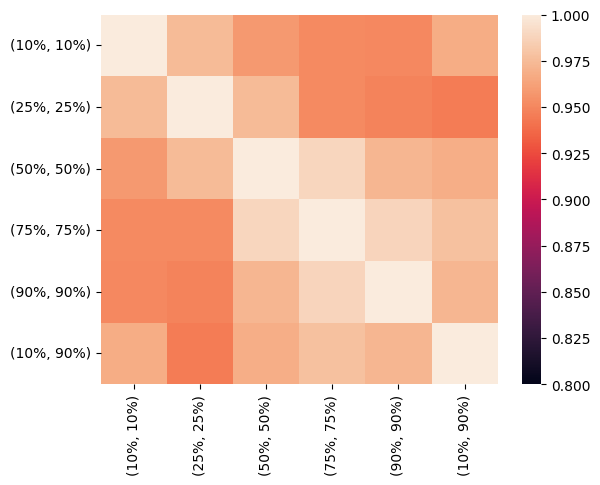

In [19]:
threshkey="smoothed_derivative"
correlate_bounds(threshkey)

### Calculating from raw derivative

/var/folders/yv/d5jpg6nn2y3bz11ly66149y00000gn/T/ipykernel_6058/494440794.py:50: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby("date").apply(normalize)
/var/folders/yv/d5jpg6nn2y3bz11ly66149y00000gn/T/ipykernel_6058/494440794.py:50: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

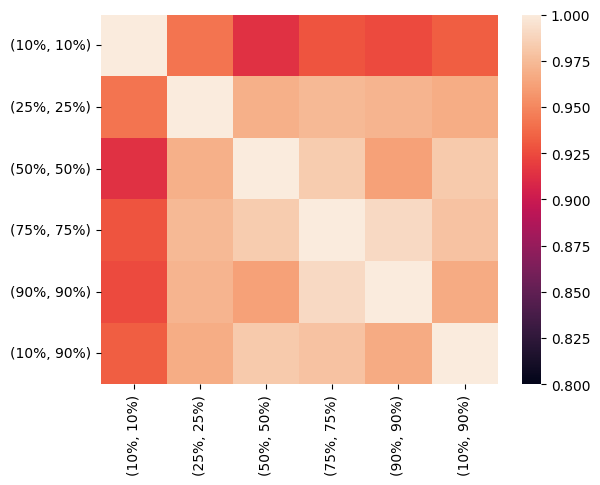

In [20]:
threshkey="derivative"
correlate_bounds(threshkey)

## Analysis within Day

### raw traces

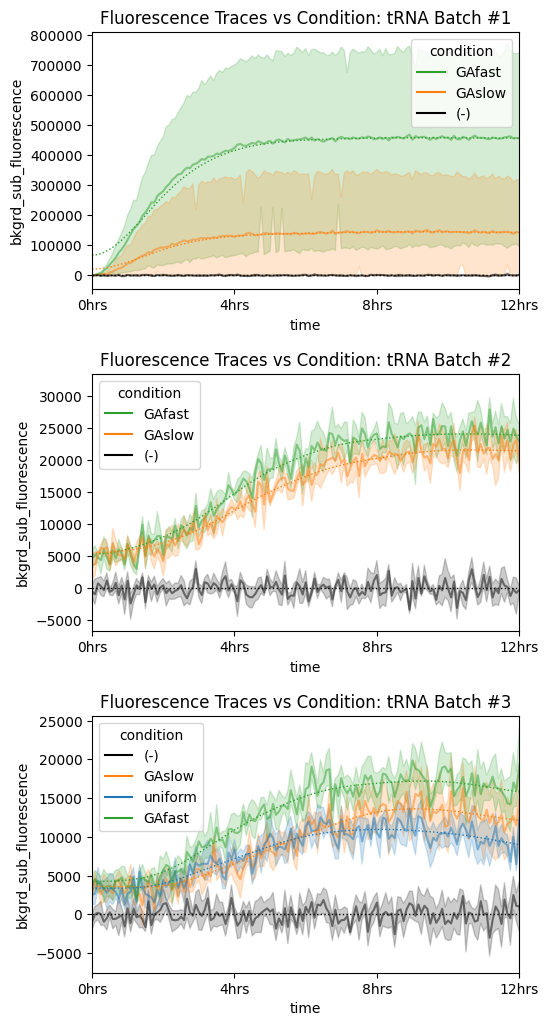

In [21]:
figsize = (5,10)

traces = get_traces_conditions(data_df)
fig, axes = plt.subplots(3,1, figsize=figsize)
fig.tight_layout(h_pad=4)
means = traces.groupby(["condition", "date", "time"])["smoothed_fluorescence"].mean().reset_index()

for i, ((date, traces_df), (date, means_df), ax) in enumerate(zip(
    traces.groupby("date"), means.groupby("date"), axes
)):
    plot_line_seaborn(
        df=traces_df, ykey="bkgrd_sub_fluorescence", 
        ax=ax, format_xaxis=False, legend=True,
    )
    plot_traces(
        plotted=means_df,
        ykey="smoothed_fluorescence", ystyle=":",
        ax=ax, format_xaxis=False,
        plot_bounds=False
    )
    set_xaxis_time(ax, last_timepoint="12hrs")
    ax.set_title(f"Fluorescence Traces vs Condition: tRNA Batch #{i+1}")
# plt.savefig("figures/all_raw_traces.svg")

### derivatives

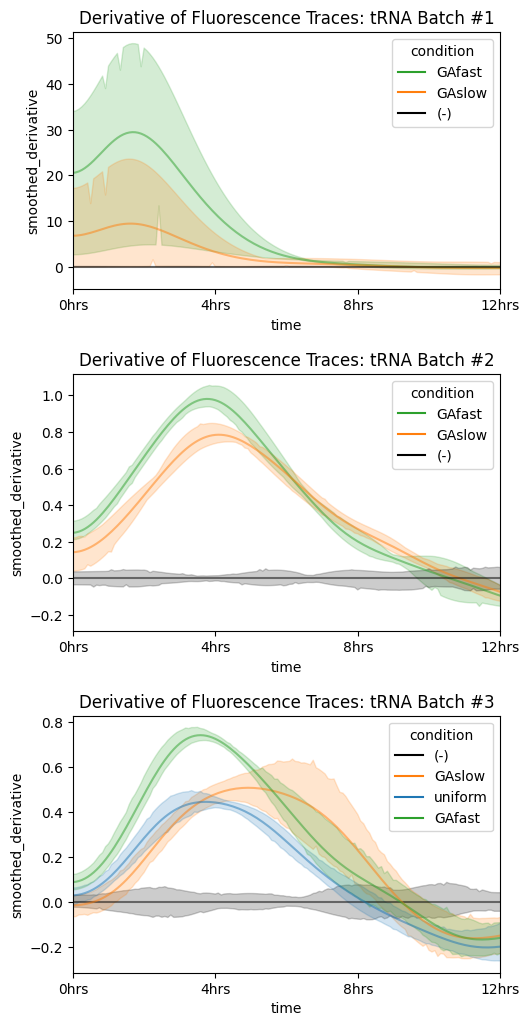

In [22]:
figsize = (5,10)

traces = get_traces_conditions(data_df)
fig, axes = plt.subplots(3,1, figsize=figsize)
fig.tight_layout(h_pad=4)

for i, ((date, traces_df),  ax) in enumerate(zip(
    traces.groupby("date"), axes
)):
    plot_line_seaborn(
        df=traces_df, ykey="smoothed_derivative", 
        ax=ax,
    )

    ax.set_title(f"Derivative of Fluorescence Traces: tRNA Batch #{i+1}")
# plt.savefig("figures/all_derivatives.svg")

### bar plots

In [23]:
means = {
    "uniform": 177.331,
    "syn Fast": 160.291,
    "syn Slow": 220.749
}
norm_rates = {
    cond: means["syn Fast"] / mean
    for cond, mean in means.items()
}
len_arr = 100
vert = np.linspace(0,1, len_arr)
vertical_lines = {
    # cond: (xarr, yarr)
    cond: (np.ones(len_arr)*rate, vert)
    for cond, rate in norm_rates.items()
}

/var/folders/yv/d5jpg6nn2y3bz11ly66149y00000gn/T/ipykernel_6058/231424359.py:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(
/var/folders/yv/d5jpg6nn2y3bz11ly66149y00000gn/T/ipykernel_6058/231424359.py:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(
/var/folders/yv/d5jpg6nn2y3bz11ly66149y00000gn/T/ipykernel_6058/231424359.py:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(


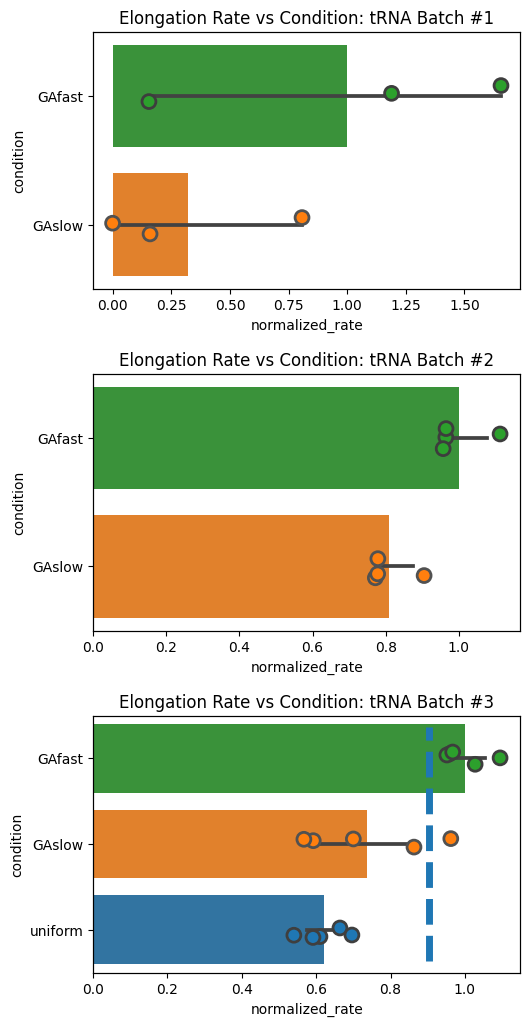

In [24]:
figsize = (5,10)

bars = get_barplot_conditions(rate_w_outliers)
fig, axes = plt.subplots(3,1, figsize=figsize)
fig.tight_layout(h_pad=4)

for i, ((date, bars_df),  ax) in enumerate(zip(bars.groupby("date"), axes)):
    ax = sns.stripplot(
        data=bars_df, x=barplotval, y="condition",
        palette=cmap, size=10, linewidth=2, ax=ax
    )
    ax = sns.barplot(
        data=bars_df, x=barplotval, y="condition",
        hue_order=hue_order, palette=cmap, orient="h",
        ax=ax
    )
    ax.set_title(f"Elongation Rate vs Condition: tRNA Batch #{i+1}")

    ax2 = ax.twinx()
    
    for cond, (xarr, yarr) in vertical_lines.items():
        if cond in set(bars_df["condition"]):
            ax2.plot(xarr, yarr, "--", color=cmap[cond], linewidth=5)
    ax2.get_yaxis().set_visible(False)
    
# plt.savefig("figures/all_bars.svg")

# Supplementary Figures

## Show elongation rate calculation 

In [25]:
rate_trace_ylims = (-5e3, 4.5e4)
rate_derivative_ylims = (-0.45, 1.15)

### negative traces and smoothing

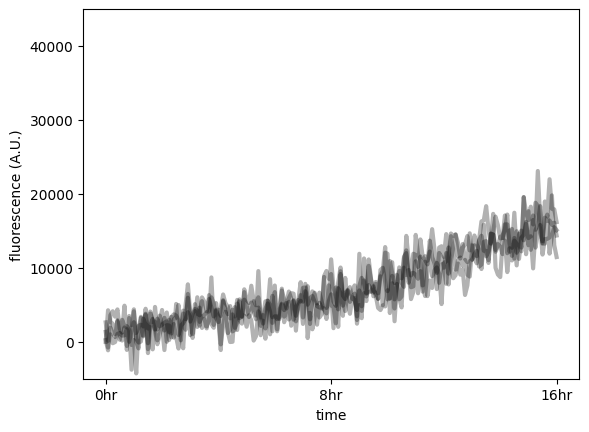

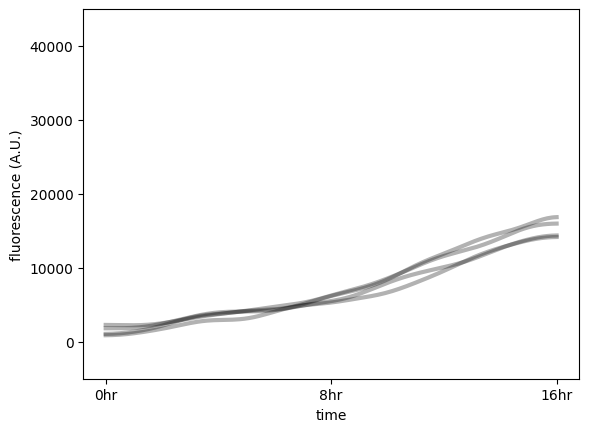

In [27]:
that_day = data_df[data_df["date"] == "220801"]

negs = that_day[that_day["condition"] == "(-)"]
for ykey in ["raw_fluorescence", "smoothed_not_bkgrd_sub"]:
    _, ax = plt.subplots()
    for _, df in negs.groupby(["loc", "date"]):
        xval = df["index"]
        yval = df[ykey]
        ax.plot(xval, yval, color='k', alpha=0.3, linewidth=3)
    xticks=[0, int(192/2), 192]
    xlabels=["0hr", "8hr", "16hr"]
    ax.set_xlabel("time")
    ax.set_ylabel("fluorescence (A.U.)")
    ax.set_xticks(xticks, xlabels)
    ax.set_ylim(rate_trace_ylims)
    # plt.savefig(f"calculate_rates_figures/negs_on_220801_ykey={ykey}.svg")

### mean negative trace

Text(0, 0.5, 'fluorescence (A.U.)')

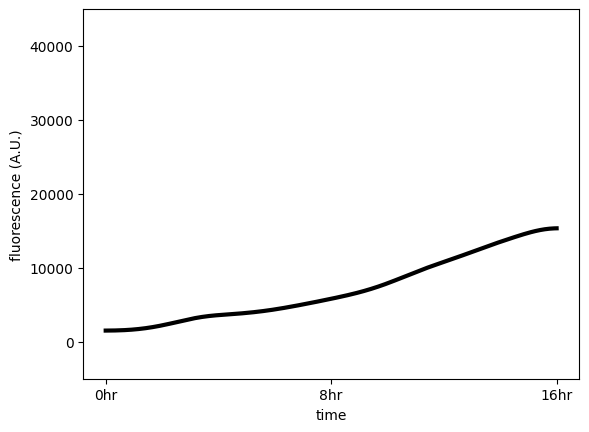

In [28]:
mean_negs = negs.groupby("time")["smoothed_not_bkgrd_sub"].mean()

_, ax = plt.subplots()
xval = mean_negs.index
yval = mean_negs
ax.plot(xval, yval, color='k', linewidth=3)
xticks=[0, int(192/2), 192]
xlabels=["0hr", "8hr", "16hr"]
ax.set_ylim(rate_trace_ylims)
ax.set_xticks(xticks, xlabels)
ax.set_xlabel("time")
ax.set_ylabel("fluorescence (A.U.)")
# plt.savefig(f"calculate_rates_figures/mean_negs.svg")

### representative fluorescence trace from same day

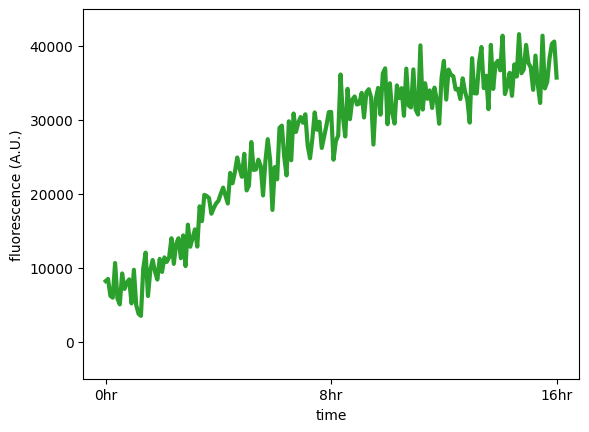

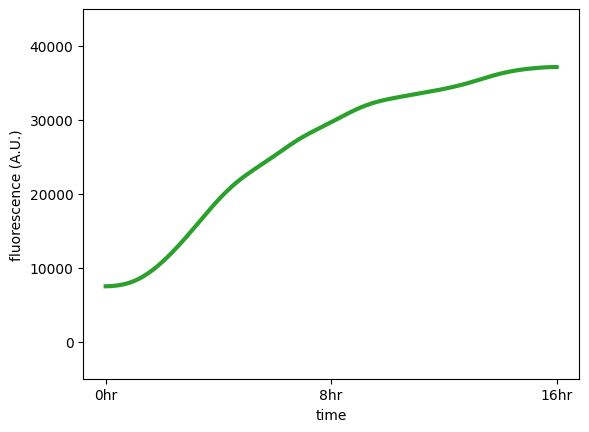

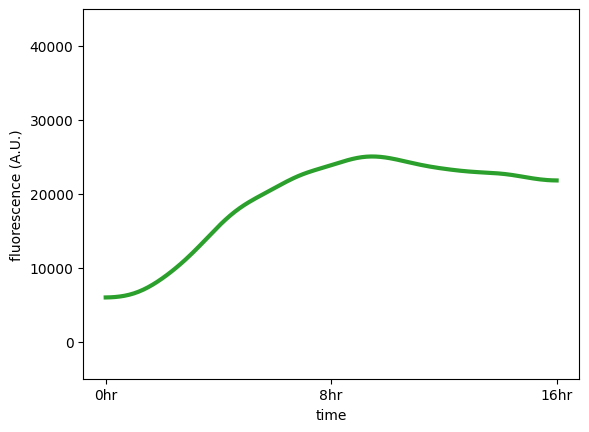

In [29]:
cond = "GAfast"
loc = "J16"
df = that_day[that_day["condition"] == cond]
trace = df[df["loc"] == loc]
for ykey in ["raw_fluorescence", "smoothed_not_bkgrd_sub", "smoothed_fluorescence"]:
    _, ax = plt.subplots()

    xval = trace["index"]
    yval = trace[ykey]
    ax.plot(xval, yval, color=cmap[cond], alpha=1, linewidth=3)
    xticks=[0, int(192/2), 192]
    xlabels=["0hr", "8hr", "16hr"]
    ax.set_xticks(xticks, xlabels)
    ax.set_ylim(rate_trace_ylims)
    ax.set_xlabel("time")
    ax.set_ylabel("fluorescence (A.U.)")
    # plt.savefig(f"calculate_rates_figures/{cond}_{loc}_{ykey}.svg")

### Numerical derivative of trace

Text(0, 0.5, 'df/dt (A.U.)')

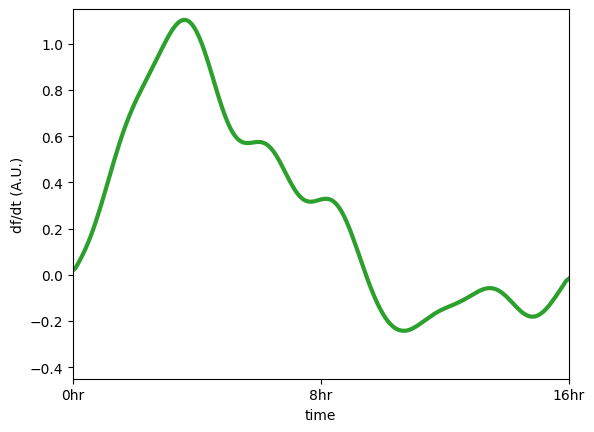

In [30]:
ax = plot_trace(
    trace, ykey="derivative",
    linewidth=3,
    plot_bounds=False
)
ax.set_ylim(rate_derivative_ylims)
ax.set_xticks(xticks, xlabels)

xticks=[0, int(192/2), 192]
xlabels=["0hr", "8hr", "16hr"]
ax.set_xlabel("time")
ax.set_ylabel("df/dt (A.U.)")
# plt.savefig("calculate_rates_figures/derivative.svg")

### Smoothed Derivative with Bounds

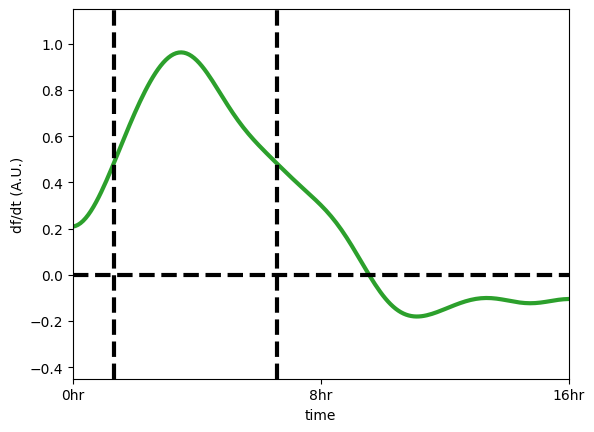

In [31]:
ax = plot_trace(
    trace, ykey="smoothed_derivative", 
    linewidth=3,
    threshkey="smoothed_derivative",
    ylim=rate_derivative_ylims,
    left_threshold=0.5, right_threshold=0.5,
)
# ax.set_ylim(rate_derivative_ylims)
ax.set_xticks(xticks, xlabels)
ax.set_xlabel("time")
ax.set_ylabel("df/dt (A.U.)")
ax.set_ylim(rate_derivative_ylims)
xticks=[0, int(192/2), 192]
xlabels=["0hr", "8hr", "16hr"]
# plt.savefig("calculate_rates_figures/smoothed_derivative_with_bounds.svg")

## init Met calibration

In [32]:
experiments = {
    # date -> (platemap_filepath, data_filepath)
    "220616": (
        "experimental_data/220616_platemap.csv", 
        "experimental_data/220616_init-Met_conc-series.csv"
    ),
}

sigma=10
left_thresh = 0.50
right_thresh = 0.50
thresh_key = "smoothed_derivative"
integrate_key = "smoothed_derivative"
barplotval = "average_rate"
vmax_flag = False


init_df = load_data(experiment_filepaths=experiments, smoothing_parameter=sigma)
init_rate_df = get_avg_rate_df(
    df=init_df,
    threshkey=thresh_key,
    leftthresh=left_thresh, 
    rightthresh=right_thresh,
    integratekey=integrate_key, vmax=vmax_flag
)

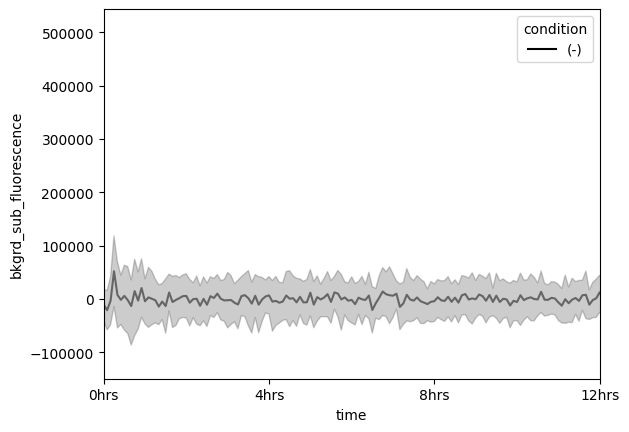

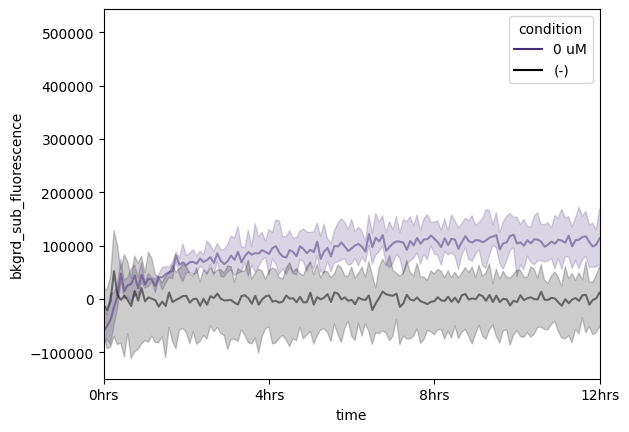

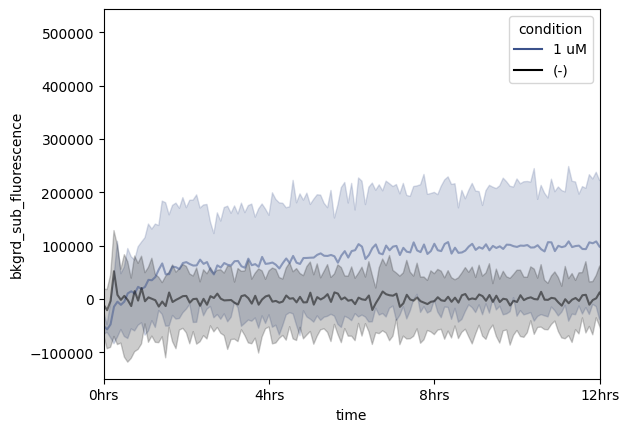

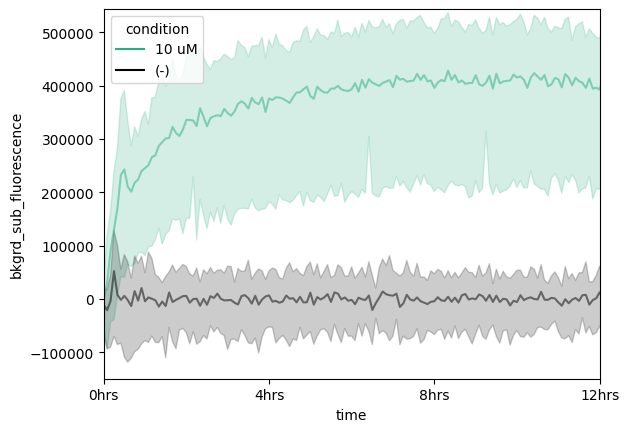

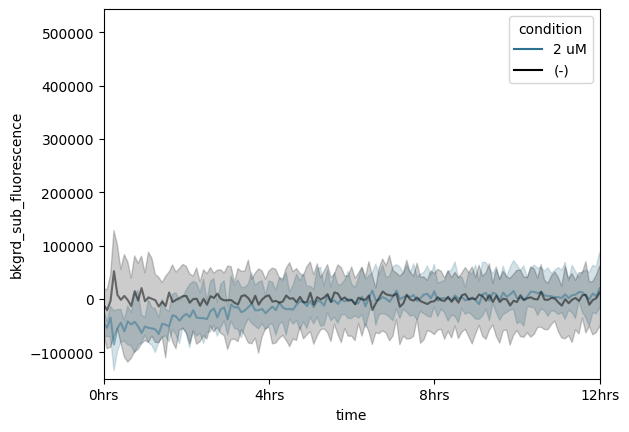

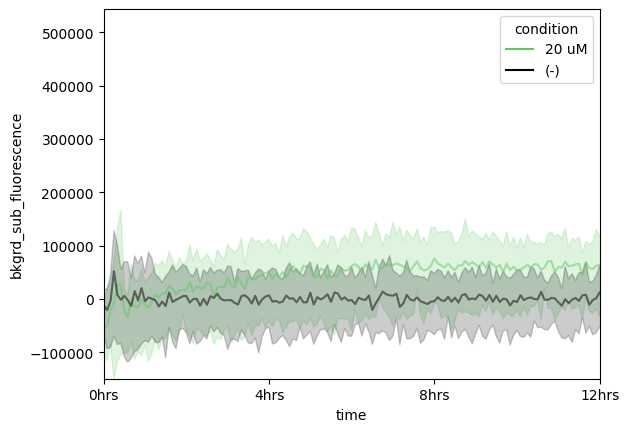

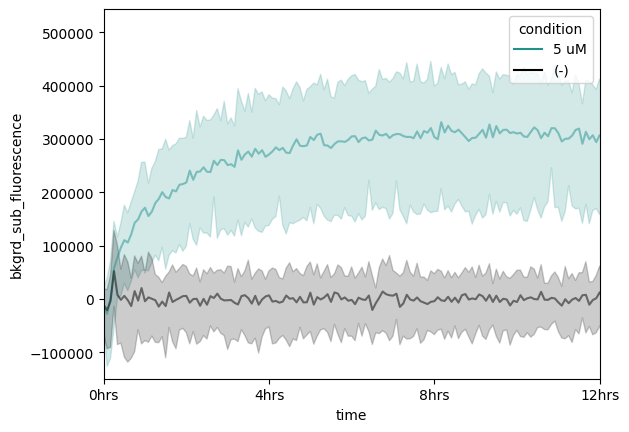

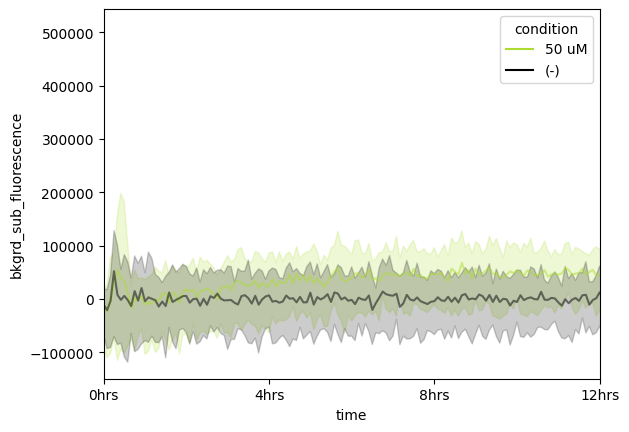

In [33]:
old_cmap = cmap
cmap = init_cmap

negs = init_df[init_df["condition"] == "(-)"]
vals = get_init_met_conditions(init_df)["bkgrd_sub_fluorescence"]
plot_bounds = (min(vals), max(vals))
for cond, df in get_init_met_conditions(init_df).groupby("condition"):
    plotted = pd.concat([df, negs])

    ax = plot_line_seaborn(
        df=plotted
    )
    ax.set_ylim(plot_bounds)
    # plt.savefig(f"init_conc_series_figures/mean_trace_cond={cond}.svg")

cmap = old_cmap


/var/folders/yv/d5jpg6nn2y3bz11ly66149y00000gn/T/ipykernel_6058/2828262072.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(


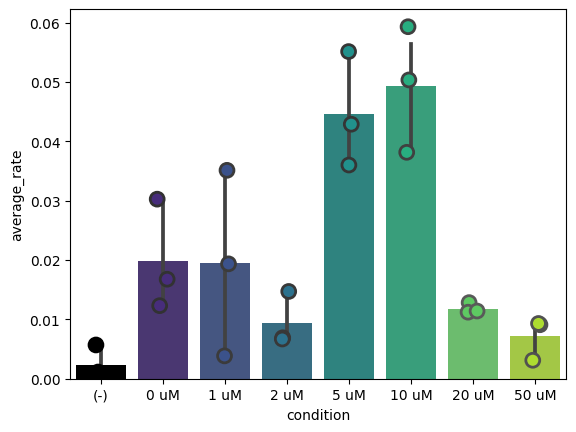

In [35]:
plotted = get_init_met_conditions(init_rate_df)
ax = sns.stripplot(
        data=plotted, x="condition", y=barplotval,
        size=10, linewidth=2, palette=init_cmap, hue_order=init_hue_order,
    order=init_hue_order
)
ax = sns.barplot(
        data=plotted, x="condition", y=barplotval,
        palette=init_cmap, order=init_hue_order
)
# plt.savefig("init_conc_series_figures/init_met_elongation_rate.svg")